In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns 

plt.style.use('ggplot')
%matplotlib inline 

    Подготовка  данных

In [4]:
df = pd.read_csv('Online Retail.csv', index_col=0)
print(df.shape)
df.head()

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 37.2+ MB


Проверяем пропуски 

In [8]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
df = df[df['CustomerID'].notnull()] # убираем строки с  пропусками в столбце CustomerID
df.shape 

(406829, 8)

In [10]:
df.isnull().sum() # снова проверяем пропуски 

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Посмотрим на топ-10 стран с униальными пользователями 

<Axes: xlabel='Country'>

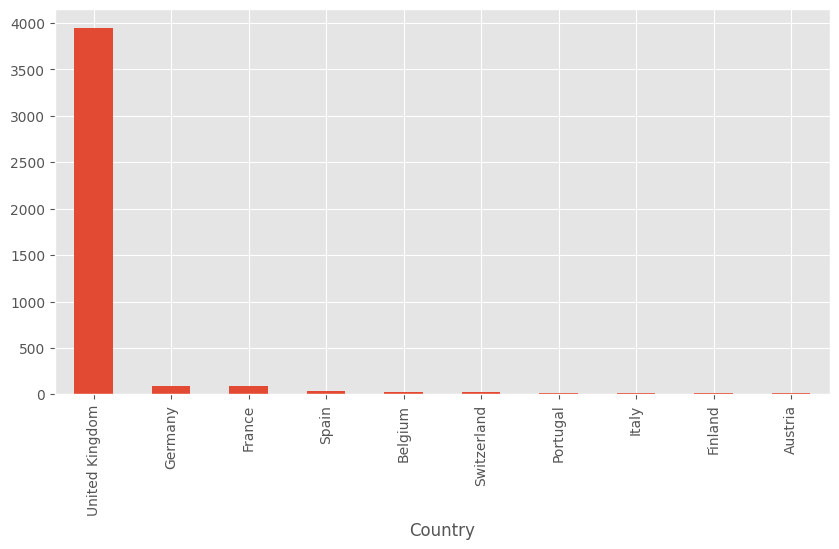

In [11]:
g = (
    df.groupby('Country')['CustomerID']
    .agg('nunique')
    .sort_values(ascending=False)[:10]
    .plot(kind='bar', figsize=(10,5))
)
g

Будем работать только с Великобританией 

In [15]:
uk_data = df[df['Country']== 'United Kingdom']
uk_data.shape

(361878, 8)

In [16]:
uk_data.describe()

,Quantity,UnitPrice,CustomerID
count,361878.000000,361878.000000,361878.000000
mean,11.077029,3.256007,15547.871368
std,263.129266,70.654731,1594.402590
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,14194.000000
50%,4.000000,1.950000,15514.000000
75%,12.000000,3.750000,16931.000000
max,80995.000000,38970.000000,18287.000000


В колонке Quantity - Кол-во есть отрицательные значения. Это явная ошибка в данных, поэтому отфильтруем заказы, оставим заказы с положительным кол-вом заказов  

In [18]:
uk_data = uk_data[uk_data['Quantity'] > 0]
uk_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354345 entries, 0 to 541893
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    354345 non-null  object 
 1   StockCode    354345 non-null  object 
 2   Description  354345 non-null  object 
 3   Quantity     354345 non-null  int64  
 4   InvoiceDate  354345 non-null  object 
 5   UnitPrice    354345 non-null  float64
 6   CustomerID   354345 non-null  float64
 7   Country      354345 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 24.3+ MB


Будем сегментировать клиентов по RFM

        * Recency (Свежесть) - число дней насколько давно клиент чтото покупал 
        * Frequency (Частота) - насколько много заказов клиент сделал 
        * Monetary (Деньги) - сколько в сумме денег потратил  

Клиенты которые пришли недавно , много и часто покупали - лучшие клиенты

In [19]:
uk_data = uk_data[['CustomerID', 'InvoiceDate', 
                   'InvoiceNo', 'Quantity', 'UnitPrice']]
uk_data.head()

,CustomerID,InvoiceDate,InvoiceNo,Quantity,UnitPrice
0,17850.0,2010-12-01 08:26:00,536365,6,2.55
1,17850.0,2010-12-01 08:26:00,536365,6,3.39
2,17850.0,2010-12-01 08:26:00,536365,8,2.75
3,17850.0,2010-12-01 08:26:00,536365,6,3.39
4,17850.0,2010-12-01 08:26:00,536365,6,3.39


In [20]:
# колонка с итоговой суммой потраченной при покупке 
uk_data['TotalPrice'] = uk_data['Quantity'] * uk_data['UnitPrice']

In [22]:
uk_data['InvoiceDate'] = pd.to_datetime(uk_data['InvoiceDate'])

In [23]:
# диапазон когда поступали заказы 
uk_data['InvoiceDate'].min(), uk_data['InvoiceDate'].max()

(Timestamp('2010-12-01 08:26:00'), Timestamp('2011-12-09 12:49:00'))

In [24]:
import datetime as dt
PRESENT = dt.datetime(2011, 12, 10)

In [25]:
rfm = (
    uk_data.groupby('CustomerID')
    .agg({
        'InvoiceDate': lambda date: (PRESENT - date.max()).days, # дней прошло с последней покупки 
        'InvoiceNo': 'count', # количество заказов
        'TotalPrice': 'sum'   # общая сумма заказов
    })
)

In [26]:
rfm.columns

Index(['InvoiceDate', 'InvoiceNo', 'TotalPrice'], dtype='object')

In [28]:
rfm.columns = ['recency', 'frequency', 'monetary']
rfm.head()

,recency,frequency,monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,103,4196.01
12748.0,0,4596,33719.73
12749.0,3,199,4090.88
12820.0,3,59,942.34


Посмотрим на то как распределены наши характеристики которые мы построили для сегментации 

array([[<Axes: title={'center': 'recency'}>,
        <Axes: title={'center': 'monetary'}>],
       [<Axes: title={'center': 'frequency'}>, <Axes: >]], dtype=object)

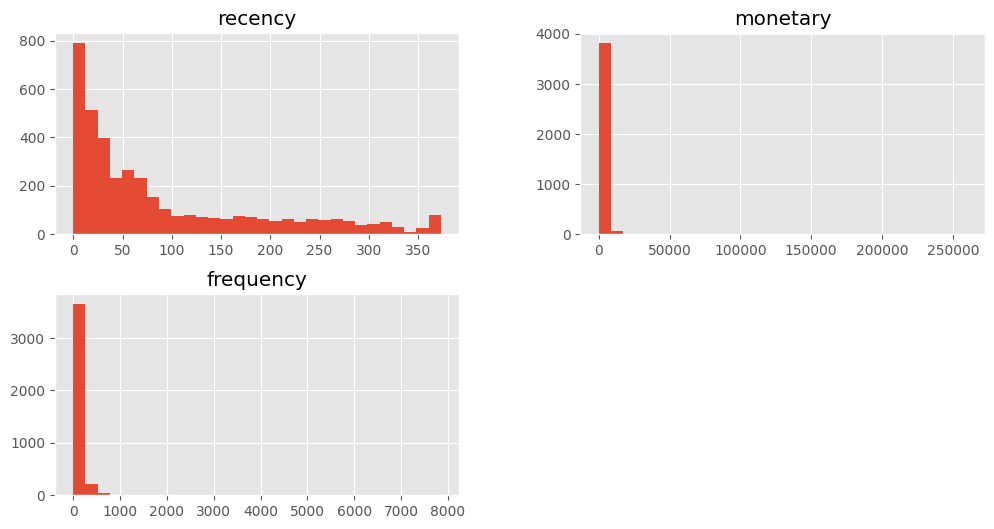

In [29]:
rfm[['recency', 'monetary', 'frequency']].hist(figsize=(12,6), bins=30)

Видим довольно длинные хвосты. Чтобы визуализация оказалась более информативной , давайте прологарифмируем наши переменные

array([[<Axes: title={'center': 'recency'}>,
        <Axes: title={'center': 'monetary'}>],
       [<Axes: title={'center': 'frequency'}>, <Axes: >]], dtype=object)

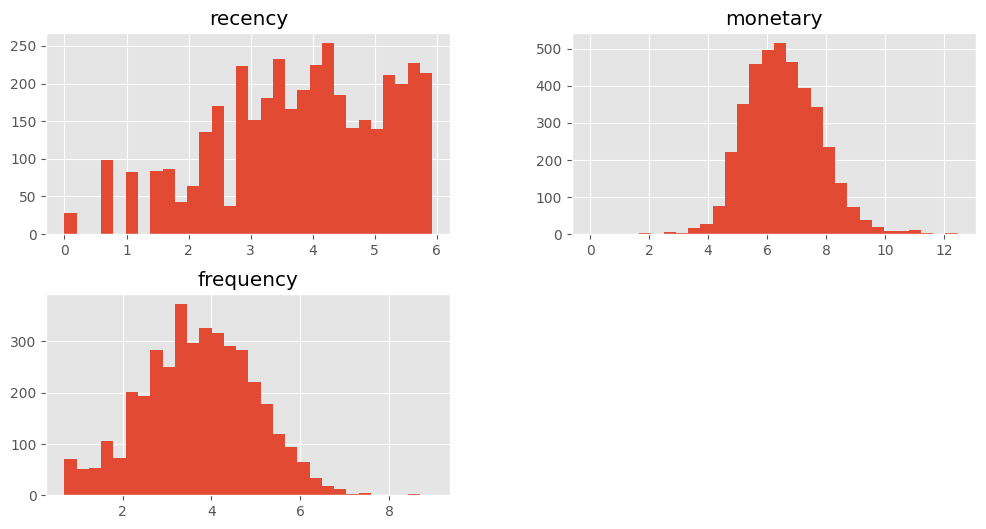

In [30]:
g = (
    rfm[['recency', 'monetary', 'frequency']]
    .apply(lambda w: np.log(w + 1))
    .hist(figsize=(12,6), bins=30)
)

g

In [31]:
rfm[['recency', 'frequency', 'monetary']] = rfm[['recency', 'frequency', 'monetary']].apply(lambda w: np.log(w + 1))

Мы будем использовать для сегментации квартили, поэтому для нас выбросы не проблема, данные от них очищать не будем. 

Номер соответствующего квартиля помогает найти команда $qcut()$ 

In [32]:
rfm['r_quartile'] = pd.qcut(rfm['recency'], 4, ['1', '2', '3', '4'])
rfm['f_quartile'] = pd.qcut(rfm['frequency'], 4, ['4', '3', '2', '1'])
rfm['m_quartile'] = pd.qcut(rfm['monetary'], 4, ['4', '3', '2', '1'])
rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile
CustomerID,,,,,,
12346.0,5.786897,0.693147,11.253955,4,4,1
12747.0,1.098612,4.644391,8.342128,1,1,1
12748.0,0.000000,8.433159,10.425868,1,1,1
12749.0,1.386294,5.298317,8.316760,1,1,1
12820.0,1.386294,4.094345,6.849427,1,2,2


Создадим единую колонку с номерами сегментов  

In [33]:
rfm['RFM_Score'] = rfm.r_quartile.astype(str) + rfm.f_quartile.astype('str') + rfm.m_quartile.astype('str')

In [36]:
rfm.head()

,recency,frequency,monetary,r_quartile,f_quartile,m_quartile,RFM_Score
CustomerID,,,,,,,
12346.0,5.786897,0.693147,11.253955,4,4,1,441
12747.0,1.098612,4.644391,8.342128,1,1,1,111
12748.0,0.000000,8.433159,10.425868,1,1,1,111
12749.0,1.386294,5.298317,8.316760,1,1,1,111
12820.0,1.386294,4.094345,6.849427,1,2,2,122


Посмотрим в какой сегмент сколько пользователей попало. Нас больше всего интересует сегмент 111, меньше всего 444

In [35]:
rfm.RFM_Score.value_counts()[:10]

RFM_Score
111    409
444    343
211    186
433    180
344    168
222    156
322    142
333    141
122    124
244    112
Name: count, dtype: int64

Для визуализации оставим только те кластеры куда попало больше 100 человек 

In [37]:
clusters = rfm['RFM_Score'].value_counts()
big_clusters = clusters[clusters > 100].index.values
big_clusters

array(['111', '444', '211', '433', '344', '222', '322', '333', '122',
       '244', '233', '443'], dtype=object)

In [38]:
import plotly.express as px

px.scatter_3d(
    rfm[rfm.RFM_Score.isin(big_clusters)],
    x='recency',
    y='frequency',
    z='monetary',
    color = 'RFM_Score'
)



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'RFM_Score=111<br>recency=%{x}<br>frequency=%{y}<br>monetary=%{z}<extra></extra>',
              'legendgroup': '111',
              'marker': {'color': '#636efa', 'symbol': 'circle'},
              'mode': 'markers',
              'name': '111',
              'scene': 'scene',
              'showlegend': True,
              'type': 'scatter3d',
              'x': array([1.09861229, 0.        , 1.38629436, ..., 2.07944154, 1.09861229,
                          1.38629436]),
              'y': array([4.6443909 , 8.4331592 , 5.29831737, ..., 5.170484  , 5.11799381,
                          6.62936325]),
              'z': array([ 8.34212765, 10.42586806,  8.3167598 , ...,  7.85090603,  8.0325485 ,
                           7.64772879])},
             {'hovertemplate': 'RFM_Score=122<br>recency=%{x}<br>frequency=%{y}<br>monetary=%{z}<extra></extra>',
              'legendgroup': '122',
              'marker': {'color': '#EF553B', 'symbol': 'circle'},
              'mode': 'markers',
              'name': '122',
              'scene': 'scene',
              'showlegend': True,
              'type': 'scatter3d',
              'x': array([1.38629436, 1.09861229, 1.09861229, 2.19722458, 1.60943791, 2.89037176,
                          2.19722458, 1.79175947, 0.        , 1.60943791, 2.48490665, 2.19722458,
                          2.56494936, 2.30258509, 2.39789527, 0.69314718, 2.89037176, 2.48490665,
                          2.39789527, 2.39789527, 2.89037176, 2.19722458, 2.89037176, 2.77258872,
                          0.69314718, 1.09861229, 2.07944154, 2.89037176, 2.56494936, 2.77258872,
                          1.60943791, 1.79175947, 0.69314718, 0.69314718, 1.38629436, 2.19722458,
                          1.38629436, 2.89037176, 2.48490665, 2.30258509, 2.39789527, 2.48490665,
                          2.48490665, 2.83321334, 1.09861229, 2.56494936, 2.19722458, 2.30258509,
                          2.07944154, 2.48490665, 1.09861229, 1.60943791, 2.30258509, 2.89037176,
                          2.7080502 , 2.7080502 , 1.09861229, 1.60943791, 0.69314718, 0.69314718,
                          0.69314718, 2.39789527, 2.83321334, 1.60943791, 1.60943791, 2.83321334,
                          0.69314718, 2.19722458, 2.19722458, 1.09861229, 2.19722458, 2.30258509,
                          2.30258509, 2.7080502 , 2.83321334, 2.56494936, 0.69314718, 2.19722458,
                          2.89037176, 2.83321334, 2.30258509, 2.48490665, 2.07944154, 2.77258872,
                          2.30258509, 2.48490665, 2.48490665, 2.89037176, 1.38629436, 1.09861229,
                          1.60943791, 2.83321334, 0.69314718, 2.89037176, 2.07944154, 1.38629436,
                          0.69314718, 2.83321334, 1.38629436, 1.38629436, 1.60943791, 1.09861229,
                          2.89037176, 2.77258872, 2.83321334, 0.69314718, 2.48490665, 2.7080502 ,
                          2.89037176, 2.19722458, 0.69314718, 2.83321334, 1.09861229, 1.38629436,
                          0.69314718, 2.7080502 , 1.79175947, 2.7080502 , 2.77258872, 1.60943791,
                          2.77258872, 2.89037176, 2.77258872, 1.09861229]),
              'y': array([4.09434456, 4.52178858, 4.04305127, 3.93182563, 3.8286414 , 4.14313473,
                          4.15888308, 4.38202663, 4.34380542, 4.12713439, 4.60517019, 3.78418963,
                          4.24849524, 4.06044301, 4.04305127, 4.14313473, 4.11087386, 3.95124372,
                          4.21950771, 4.60517019, 3.76120012, 3.80666249, 4.06044301, 4.11087386,
                          4.34380542, 4.18965474, 4.09434456, 3.91202301, 4.44265126, 4.46590812,
                          3.78418963, 4.38202663, 3.97029191, 3.87120101, 4.20469262, 3.87120101,
                          4.12713439, 4.14313473, 4.2341065 , 4.34380542, 3.8918203 , 4.02535169,
                          4.09434456, 3.8501476 , 4.39444915, 4.07753744, 4.27666612, 4.30406509,
             